# Simplicial Complexes and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Simplicial Homology

This week, we introduced homology of simplicial complexes. The *$k$th homology* is a machine which eats a simplicial complex $X$ and spits out a vector space $H_k(X)$ whose elements are equivalence classes of simplices representing "$k$-dimensional holes" in the complex $X$. 

This should lead you to a natural

**Question:** What does homology have to do with data analysis?

That is, most datasets that you deal with are not naturally structured as simplicial complexes. But this statement is not *quite* true: typical data is a finite set of points in $\mathbb{R}^n$ (or some other metric space), and a finite set of points can be considered as a (somewhat boring) simplicial complex. In particular, if $X$ is a set of $n$ points, then 
$$
H_k(X) \approx \left\{\begin{array}{cc}
                \mathbb{F}_2^n & k = 0 \\
                0 & k \neq 0; \end{array}\right.
$$
i.e., homology just tells us the number of points in $X$ (not very interesting...).

The idea we will persue in coming weeks is to use the vertex set $X$ to create increasingly complicated simplicial complexes which capture the geometry and topology of $X$ at many scales.

To motivate this, let's construct a toy dataset.

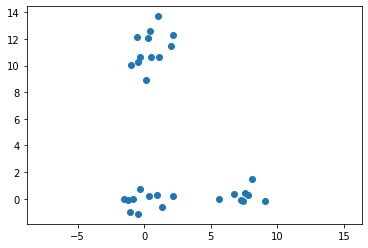

In [2]:
X1 = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 10)
X2 = np.random.multivariate_normal([7,0],np.array([[1,0],[0,0.2]]),size = 8)
X3 = np.random.multivariate_normal([0,11],np.array([[1,0],[0,1]]),size = 12)

X = np.concatenate((X1,X2,X3))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

## Back to Clustering

Recall that one of our motivations for studying topology in the context of data analysis was hierarchical clustering.

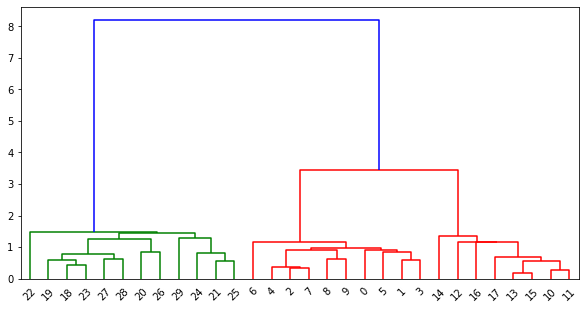

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage  

plt.figure(figsize=(10,5))
linked = linkage(X)
dendrogram(linked)
plt.show()

This gives a multiscale picture of the clustering structure of the data. But "clusters" are just connected pieces of the data; i.e., elements of $H_0(X)$. The idea is that hierarchical clustering is finding $H_0(X)$ at various levels of 'resolution' in the data.

Now let's try to make this precise.

## Creating a Growing Simplicial Complex

For each $r \geq 0$, define a simplicial complex $X_r = (V_r, \Sigma_r)$, where
$$
V_r = X \qquad \forall r
$$
and $\Sigma_r$ contains only $0$-simplices and $1$-simplices, where the $1$-simplices form the set
$$
\{\{x_i,x_j\} \mid x_i,x_j \in X, d(x_i,x_j) \leq r\},
$$
where $d(x_i,x_j)$ is Euclidean distance.

**Note:** $X_0 = X$.

Let's write a function to generate such a simplicial complex for each $r \geq 0$. 

First we create a distance matrix for $X$.

In [4]:
from sklearn.metrics import pairwise_distances

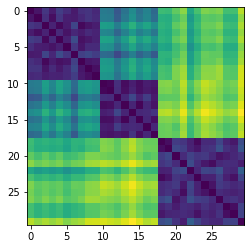

In [5]:
D = pairwise_distances(X)
plt.imshow(D)
plt.show()

In [7]:
def create_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

Try it out:

/Users/needham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


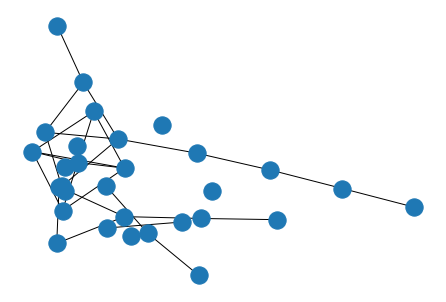

In [8]:
r = 1
G = create_simplicial_complex(D,r)
nx.draw_kamada_kawai(G)

It looks like the function works, but we would like our drawings to be more related to the original dataset. We can set node positions in `networkx` graphs (there are lots of other options for visualization here).

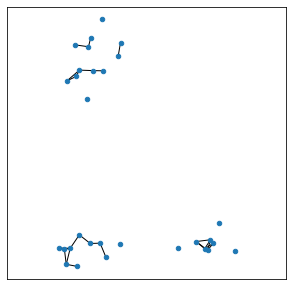

In [9]:
pos = {n:X[n,:] for n in range(len(X))}
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

Now let's look at how this evolves over a few radii:

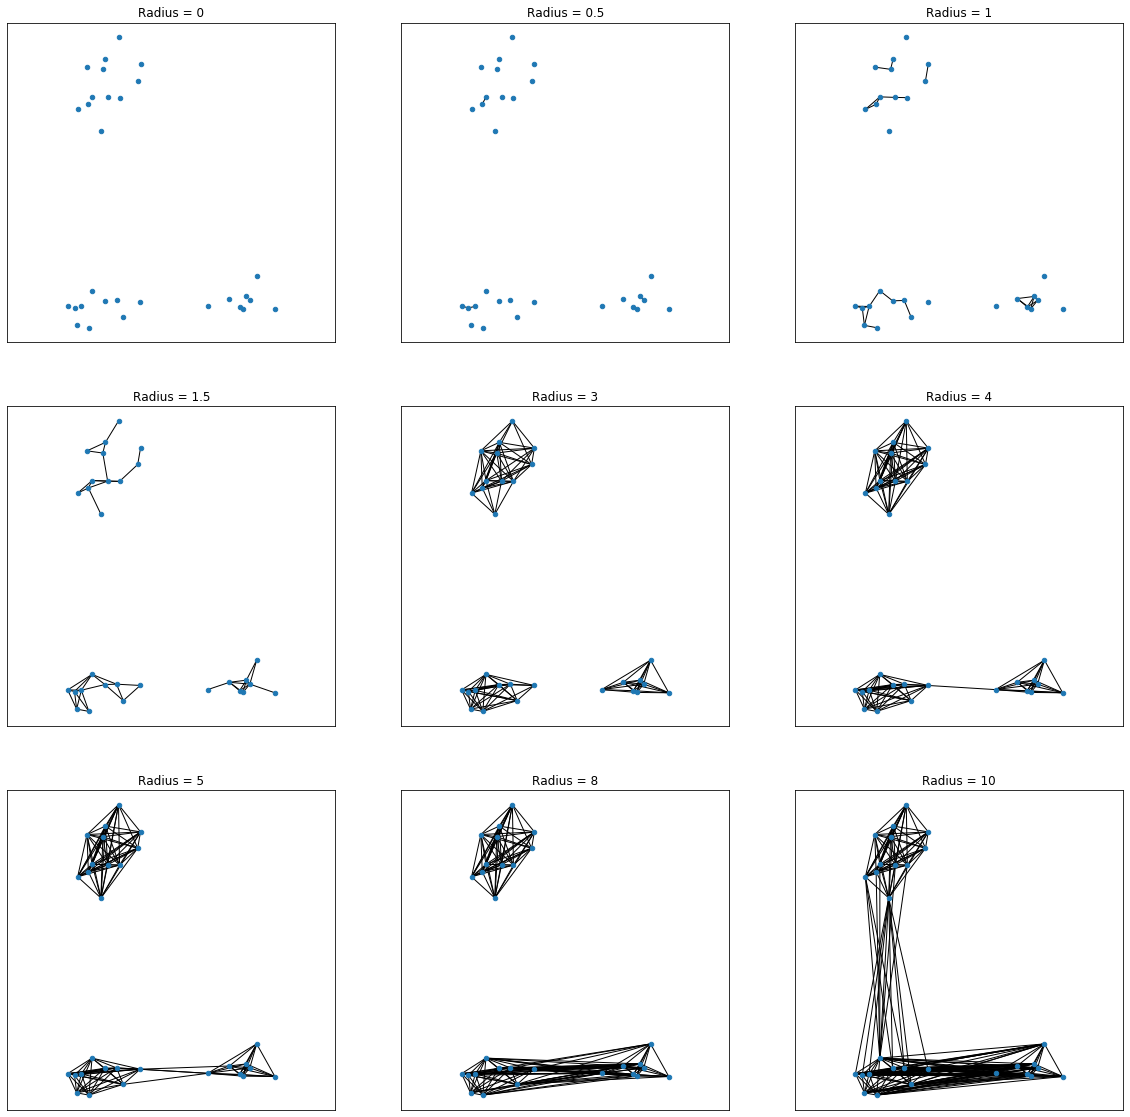

In [10]:
rs = [0,0.5,1,1.5,3,4,5,8,10]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

Compare again to the dendrogram from above.

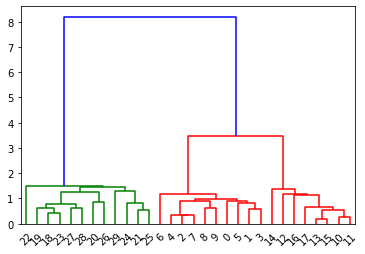

In [11]:
dendrogram(linked)
plt.show()

Observe that the heights where clusters merge correspond exactly to the radii $r$ where the corresponding equivalence classes merge in $H_0(X_r)$. 

## Vietoris-Rips Complexes

The above construction is (almost) an example of the concept of a *Vietoris-Rips complex* that we defined in class. Recall that if $(X,d)$ is a finite metric space and $r \geq 0$, we define the *Vietoris-Rips complex for $X$ at scale $r$* to be the simplicial complex $\mathrm{VR}_r(X) = (V_r,\Sigma_r)$, where $V_r = X$ for all $r$ and 
$$
\Sigma_r = \{(x_{i_0},\ldots,x_{i_k}) \mid d(x_{i_m},x_{i_n}) \leq r \; \forall \; m,n\}.
$$
The graphs we defined above are the $1$-skeleton of the Vietoris-Rips complexes at various scales; that is, they are the result of taking the Vietoris-Rips complex and throwing away any simplices with dimension $\geq 2$. This is sufficient to extract connectivity information about the data, but there is a reason to include higher-dimensional simplices in the construction.

## Higher-Dimensional Homology

To see how higher-dimensional homology would come into play, let's look at one more example.

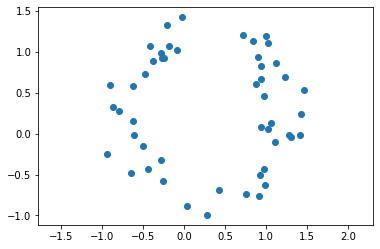

In [25]:
num_points = 50

X = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points)
X = X.T/np.linalg.norm(X,axis = 1)
X = X.T + 0.5*np.random.rand(num_points,2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [26]:
D = pairwise_distances(X)

The $1$-skeleta of the Vietoris-Rips complexes look like this:

/Users/needham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


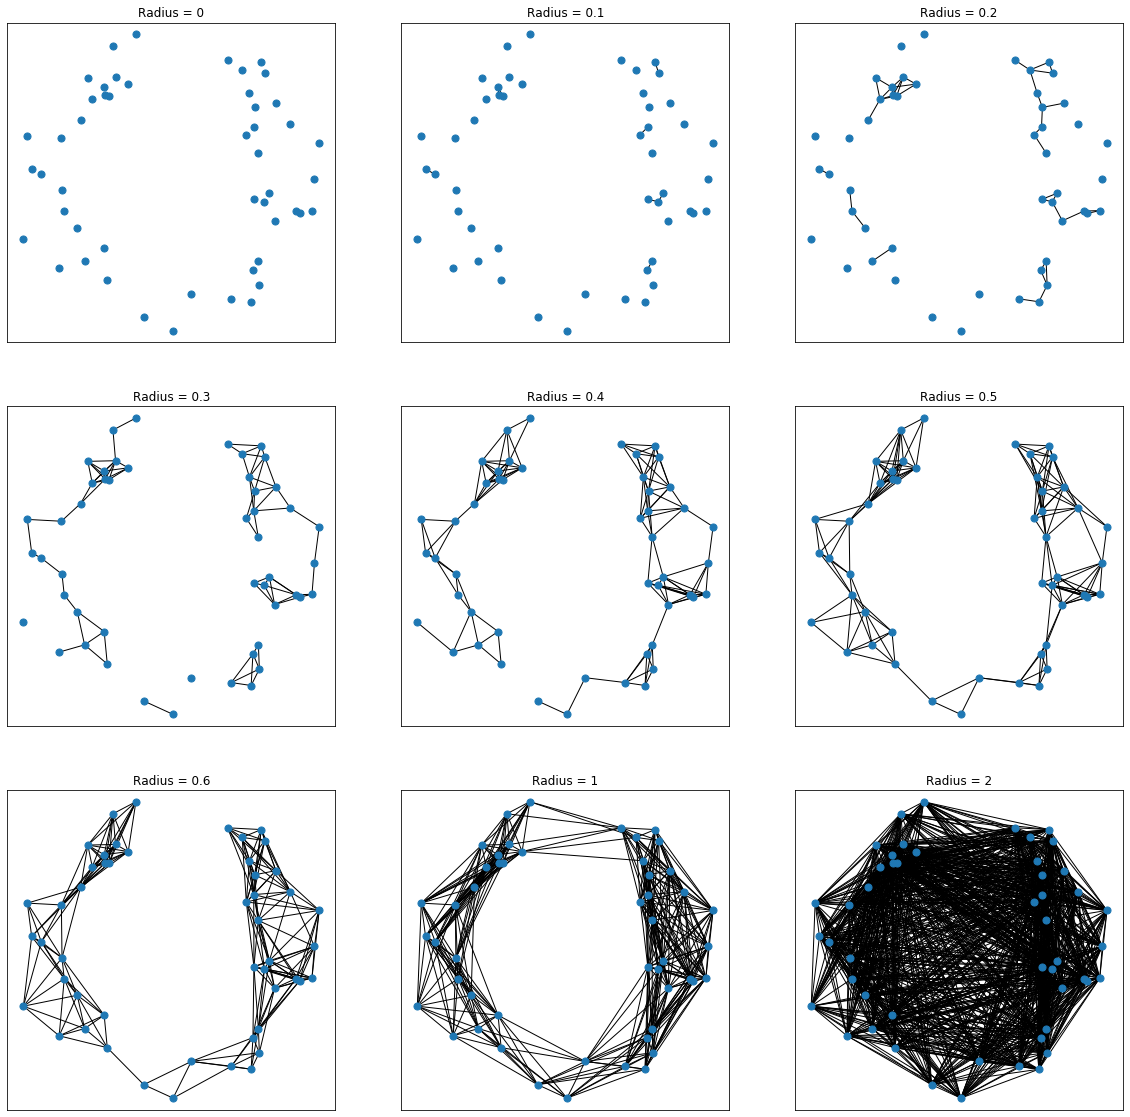

In [27]:
rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

For this dataset, there is a 'loop structure' which may be of interest. To see it computationally, we would want to track $1$-dimensional homology over various scales. As it stands, the 1-dimensional homology would see lots and lots of very small holes, which would not sufficiently accentuate the large apparent loop. We can remedy this by including higher-dimensional simplices.

In what follows, I'll compute the $2$-skeleton of the Vietoris-Rips complexes. Note that if we are interested in degree-$k$ homology of the dataset, it suffices to use the $k+1$-skeleton of the VR complex, since
$$
H_k(\mathrm{VR}_r(X)) = \mathrm{ker}(\partial_k) / \mathrm{im}(\partial_{k+1}).
$$

We need to use some more involved tools to compute and draw $2$-simplices.

Let's work at a fixed resolution to design the plotting tool.

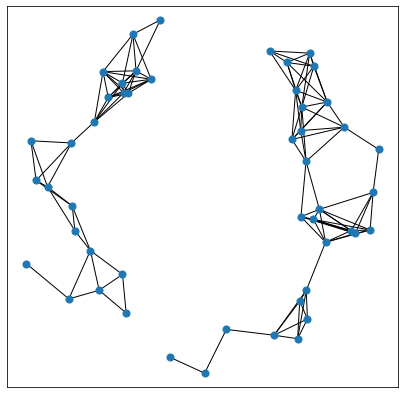

In [28]:
plt.figure(figsize = (7,7))
r = 0.4
G = create_simplicial_complex(D,r)
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
plt.axis('equal')
plt.show()

In [29]:
def create_2_dim_simplicial_complex(D,r):
    
    # Create 1-skeleton
    G = create_simplicial_complex(D,r)
    
    # Get a list of 2-simplices
    two_spx_list = []
    
    # Naive search for viable 2-simplices
    for edge in G.edges():
        for vertex in G.nodes():
            if vertex != edge[0] and vertex != edge[1] and D[edge[0],vertex] < r and D[edge[1],vertex] < r:
                two_spx_list.append([edge[0],edge[1],vertex])
                
    return G, two_spx_list

In [30]:
G, two_spx_list = create_2_dim_simplicial_complex(D,r)
two_spx_list

[[0, 15, 30],
 [0, 15, 38],
 [0, 15, 45],
 [0, 30, 15],
 [0, 30, 31],
 [0, 30, 38],
 [0, 30, 45],
 [0, 31, 30],
 [0, 38, 15],
 [0, 38, 30],
 [0, 38, 45],
 [0, 45, 15],
 [0, 45, 30],
 [0, 45, 38],
 [1, 4, 24],
 [1, 16, 34],
 [1, 24, 4],
 [1, 34, 16],
 [1, 34, 43],
 [1, 43, 34],
 [2, 7, 8],
 [2, 7, 12],
 [2, 7, 23],
 [2, 7, 37],
 [2, 7, 47],
 [2, 8, 7],
 [2, 8, 12],
 [2, 8, 23],
 [2, 8, 37],
 [2, 8, 47],
 [2, 12, 7],
 [2, 12, 8],
 [2, 12, 23],
 [2, 12, 37],
 [2, 12, 47],
 [2, 23, 7],
 [2, 23, 8],
 [2, 23, 12],
 [2, 23, 37],
 [2, 23, 47],
 [2, 37, 7],
 [2, 37, 8],
 [2, 37, 12],
 [2, 37, 23],
 [2, 47, 7],
 [2, 47, 8],
 [2, 47, 12],
 [2, 47, 23],
 [3, 4, 24],
 [3, 22, 46],
 [3, 22, 48],
 [3, 24, 4],
 [3, 24, 46],
 [3, 46, 22],
 [3, 46, 24],
 [3, 46, 48],
 [3, 48, 22],
 [3, 48, 46],
 [4, 24, 1],
 [4, 24, 3],
 [5, 28, 36],
 [5, 28, 38],
 [5, 28, 40],
 [5, 28, 45],
 [5, 36, 28],
 [5, 36, 38],
 [5, 36, 40],
 [5, 36, 45],
 [5, 38, 28],
 [5, 38, 36],
 [5, 38, 40],
 [5, 38, 45],
 [5, 40, 28],
 [5,

To draw the simplices, we'll use the `Polygon` function imported above. We'll add the triangles one-by-one to a collection, then use plotting tools to display them.

In [31]:
patches = []

for i,spx in enumerate(two_spx_list):
    position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
    polygon = Polygon(position_array, True)
    patches.append(polygon)

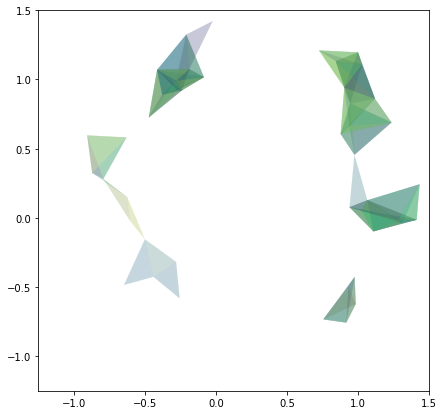

In [32]:
fig, ax = plt.subplots(figsize = (7,7))

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.xlim([-1.25, 1.5])
plt.ylim([-1.25, 1.5])
plt.show()

Now we'll plot the 1-skeleton first and overlay the triangles.

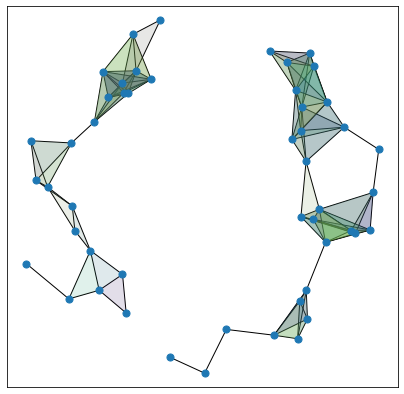

In [33]:
fig, ax = plt.subplots(figsize = (7,7))

nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.05)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('equal')
plt.show()

Looks good! Now let's run it on a range of radii. We'll decrease the max radius in our pictures, since the number of triangles blows up factorially and it eventually takes forever to draw all of them.

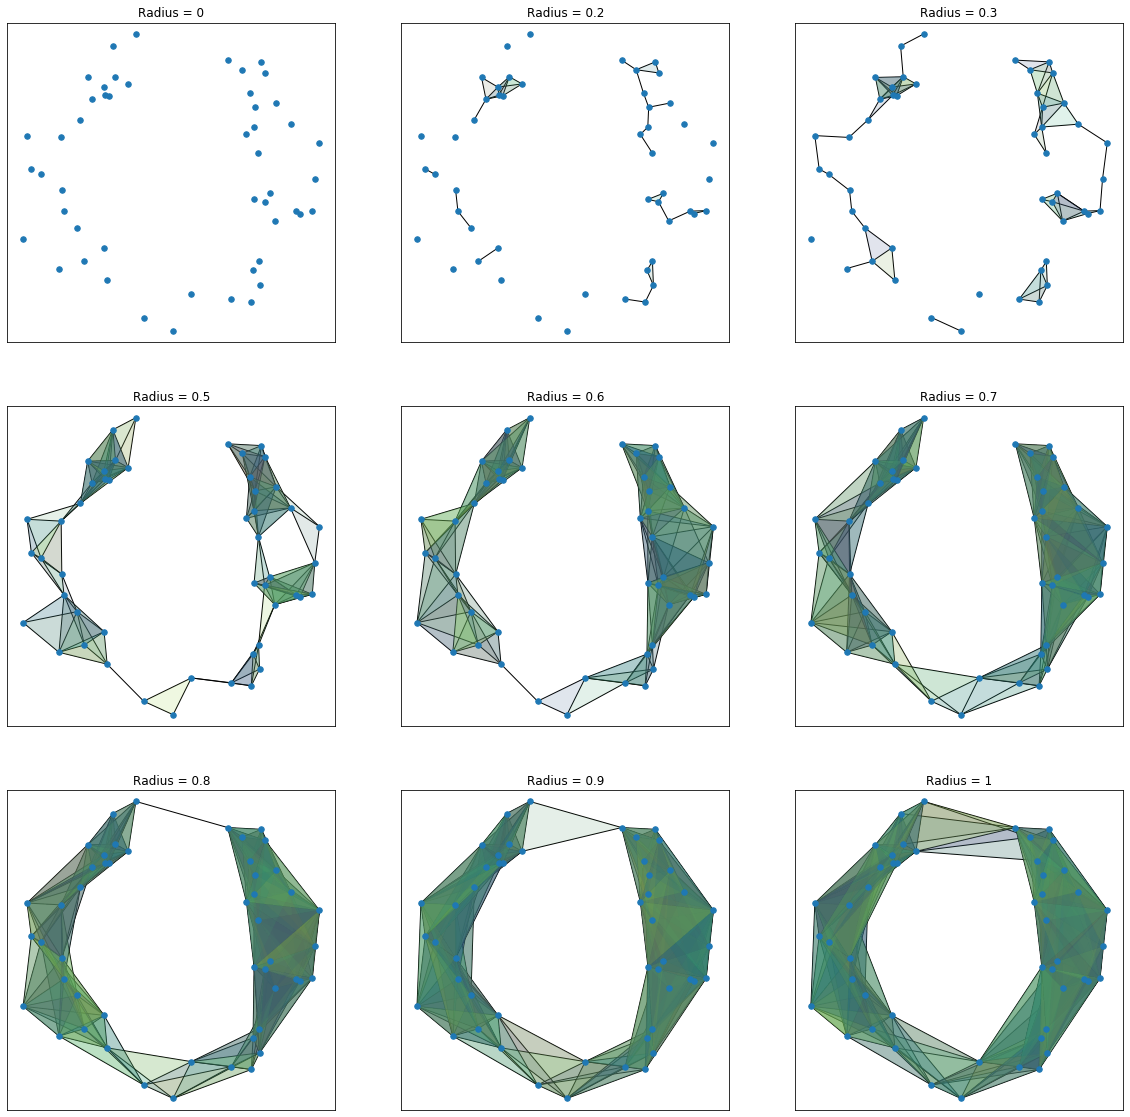

In [34]:
rs = [0,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

We see that loops appear in the data:
- small loops appear earlier in the process but are quickly filled in
- a much stronger loop appears a bit later but persists for a long time
- the large loop will also eventually be filled in, but the idea is that keep track of how features change over 'filtration values' (values of $r$).

## Persistent Homology

In class, we defined the *$k$th Vietoris-Rips persistence module of $X$* to consist of the following data:
- For each $r \geq 0$, we have a vector space
$$
H_k(\mathrm{VR}_r(X))
$$
- For each pair $r,s$ with $r \leq s$, we have a linear map
$$
H_k(\mathrm{VR}_r(X)) \to H_k(\mathrm{VR}_s(X))
$$
which is induced (by functoriality!) by the simplicial map $\mathrm{VR}_r(X) \to \mathrm{VR}_s(X)$ coming from the identity map on the vertex set $X$.

This structure is also referred to as the *persistent homology* of the Vietoris-Rips complex.

This is a very rich/complex way to encode information about the dataset $X$. This should lead you to the following

**Question:** How can a persistence module be used in practice?

That is, we need ways to 
- conveniently represent and visualize persistence modules, and
- compare persistence modules coming from different datasets.

## Persistence Diagrams and Barcodes

To address the first part of the question, here is some code which can be used to represent/visualize persistence modules.

**Remark:** From now on, we will start using more specialized software packages. If you are following along on your machine, it's possible that installation of these packages will not be as straightforward as it is for more 'mainstream' packages. Talk with me in office hours if you need some help with installation, or you can always follow along using the Binder link on the GitHub page.

We'll use a TDA package called `gudhi`. Documentation for the package is here: http://gudhi.gforge.inria.fr.

In [36]:
import gudhi as gd

Let's first study the dataset that we were looking at above. In `gudhi`, we create the Vietoris-Rips complex using the following functions. I'm passing in some options which will only construct the $2$-skeleton of the VR complex.

In [39]:
skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 2) 
Rips_complex = skeleton.create_simplex_tree(max_dimension = 2)

The VR complex is stored as a simplicial complex, together with a 'filtration' value for the simplex. This is the radius at which the simplex first appears in $\mathrm{VR}_r(X)$. 

Let's see how many simplices there are and print off the first couple of hundred to see what the structure looks like.

In [40]:
rips_filtration = Rips_complex.get_filtration()
rips_list = list(rips_filtration)
print('Number of Simplices:',len(rips_list))
for splx in rips_list[0:200] :
    print(splx)

Number of Simplices: 14520
([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([28, 40], 0.03140539453537742)
([8, 23], 0.03438330079367454)
([28, 38], 0.06674471802964688)
([7, 12], 0.08000262595413975)
([38, 40], 0.0806408919251181)
([28, 38, 40], 0.0806408919251181)
([10, 20], 0.08544413447683279)
([19, 41], 0.08548767652406813)
([12, 47], 0.08753192372526723)
([3, 46], 0.08998451864220276)
([13, 49], 0.09426755772485826)
([8, 37], 0.10406121668728936)
(

Okay... so now we have a VR complex. But what do we do with it? The following code computes the persistence module for the Vietoris-Rips complex and represents it in a particular way.

In [41]:
BarCodes = Rips_complex.persistence()

Looking at the result...

In [42]:
BarCodes

[(1, (0.7768636995768041, 1.3901371918960546)),
 (1, (0.34047740908306384, 0.5052799135014928)),
 (1, (0.40131073628720965, 0.4475284256583195)),
 (0, (0.0, inf)),
 (0, (0.0, 0.423597278698615)),
 (0, (0.0, 0.37846032670475827)),
 (0, (0.0, 0.3549847114676392)),
 (0, (0.0, 0.3339778684937402)),
 (0, (0.0, 0.32881555521489625)),
 (0, (0.0, 0.29666317571172296)),
 (0, (0.0, 0.28068843227088963)),
 (0, (0.0, 0.27777046657752763)),
 (0, (0.0, 0.27393955148890625)),
 (0, (0.0, 0.2734463262514909)),
 (0, (0.0, 0.26296301914041964)),
 (0, (0.0, 0.2577493369901209)),
 (0, (0.0, 0.2506999828999972)),
 (0, (0.0, 0.24176365148730292)),
 (0, (0.0, 0.2154936789627401)),
 (0, (0.0, 0.21343331671727273)),
 (0, (0.0, 0.21323121823439847)),
 (0, (0.0, 0.21131470197267474)),
 (0, (0.0, 0.2079762884783195)),
 (0, (0.0, 0.1998258885259827)),
 (0, (0.0, 0.19296626185862178)),
 (0, (0.0, 0.19208914590825452)),
 (0, (0.0, 0.1916427888783207)),
 (0, (0.0, 0.17867202693494297)),
 (0, (0.0, 0.17692349916455777)

So it's a bunch of things of the form $(d,(x,y))$. We can plot these things in a couple of ways. Let's see if we can guess what this representation is telling us about the data.

The following is called a *persistence diagram*.

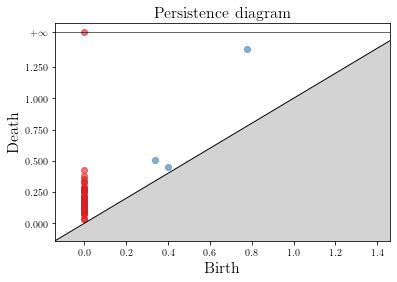

In [43]:
gd.plot_persistence_diagram(BarCodes)
plt.show()

The following is called a *barcode representation*.

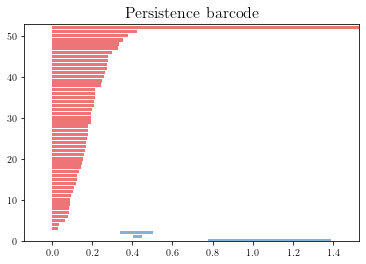

In [44]:
gd.plot_persistence_barcode(BarCodes)
plt.show()

Any guesses for what this represents?

## Another Example

Let's run this pipeline on one more example to get an intuitive feel for how it works.

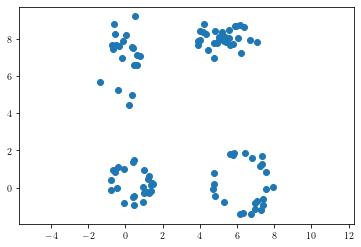

In [47]:
A = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 25)
A = A.T/np.linalg.norm(A,axis = 1)
A = A.T + 0.5*np.random.rand(25,2)

Y = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 25)
Y = 1.5*Y.T/np.linalg.norm(Y,axis = 1)
Y = Y.T + 0.5*np.random.rand(25,2) + [6,0]

Z1 = np.random.multivariate_normal([0,7],np.array([[0.2,0],[0,1]]),size = 20)
Z2 = np.random.multivariate_normal([5,8],np.array([[1,0],[0,0.2]]),size = 30)

X = np.concatenate((A,Y,Z1,Z2))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [48]:
D = pairwise_distances(X)

Radius 0 done...
Radius 0.25 done...
Radius 0.5 done...
Radius 0.75 done...


/Users/needham/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Radius 1 done...
Radius 1.25 done...
Radius 1.5 done...
Radius 2 done...
Radius 2.5 done...


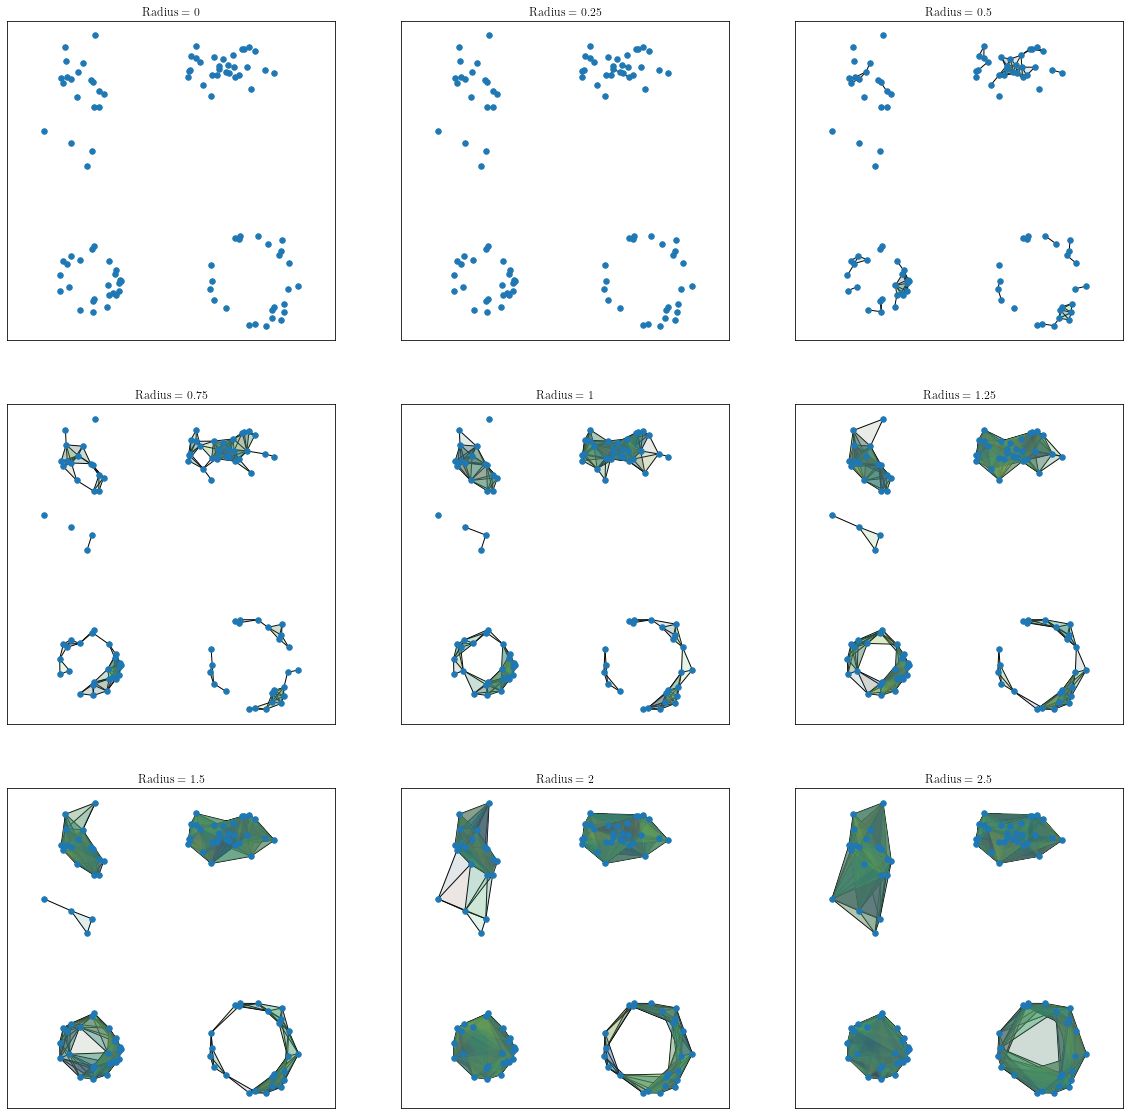

In [49]:
rs = [0,0.25,0.5,0.75,1,1.25,1.5,2,2.5]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    print('Radius',r,'done...')
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

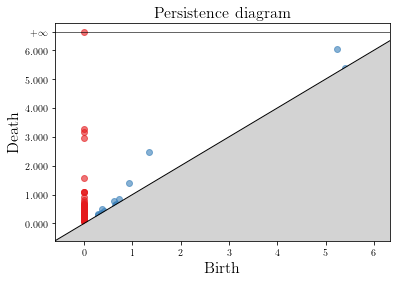

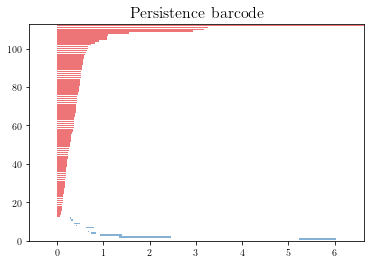

In [50]:
skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 10) 
Rips_complex = skeleton.create_simplex_tree(max_dimension = 2)
BarCodes = Rips_complex.persistence()

gd.plot_persistence_diagram(BarCodes)
plt.show()

gd.plot_persistence_barcode(BarCodes)
plt.show()

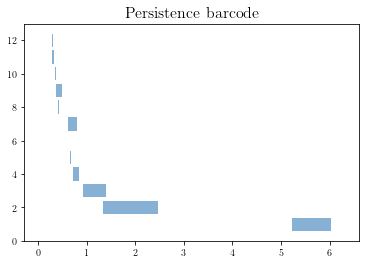

In [51]:
gd.plot_persistence_barcode([bar for bar in BarCodes if bar[0] == 1])
plt.show()

## Next Steps

Our plan for next week is to precisely understand what the points in the persistence diagram/bars in the barcodes represent. 

## Unofficial Homework

Try running through this pipeline for other point clouds; either toy datasets of your own design, toy datasets from, say, `scikit-learn`, or a real world dataset.

For point clouds with more points, the visualization part may become too unwieldy. If you use point clouds in higher dimensions, then the visualization will not work at all. It would be a fun exercise to extend these visualizations to work for 3D point clouds. Beyond that, you could visualize via projections. In any case, the persistent homology code should work in any dimension and works reasonably quickly for larger point clouds. 

Let me know if you find anything interesting!